In [25]:
%matplotlib inline

import datetime
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt


# Reduces variance in results but won't eliminate it :-(
%env PYTHONHASHSEED=0
import random
random.seed(42)
np.random.seed(42)

env: PYTHONHASHSEED=0


# Baseline Forecasts for Cambridge UK Weather Time Series

Building baseline models for time series analysis of Cambridge UK temperature measurements taken at the [University computer lab weather station](https://www.cl.cam.ac.uk/research/dtg/weather/).

See previous work for further details:
 * [Cambridge UK temperature forecast python notebooks](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks)
 * [Cambridge UK temperature forecast R models](https://github.com/makeyourownmaker/CambridgeTemperatureModel)
 * [Bayesian optimisation of prophet temperature model](https://github.com/makeyourownmaker/BayesianProphet)
 * [Cambridge University Computer Laboratory weather station R shiny web app](https://github.com/makeyourownmaker/ComLabWeatherShiny)

I'm primarily interested in short term temperature forecasts (less than 2 hours). 


## Import Data

The measurements are quite noisy.
Data has been extensively cleaned but may still have issues.  There are currently no missing values.  See the [cleaning section](https://github.com/makeyourownmaker/CambridgeTemperatureModel#Cleaning) in the [Cambridge Temperature Model repository](https://github.com/makeyourownmaker/CambridgeTemperatureModel) for details.  Observations start in August 2008 and end in April 2021 and occur every 30 mins.

Shape:
(220870, 7)

Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 220870 entries, 25 to 220894
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ds                 220870 non-null  datetime64[ns]
 1   y                  220870 non-null  float64       
 2   humidity           220870 non-null  float64       
 3   dew.point          220870 non-null  float64       
 4   pressure           220870 non-null  float64       
 5   wind.speed.mean    220870 non-null  float64       
 6   wind.bearing.mean  220870 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 13.5 MB
None

Summary stats:


,y,humidity,dew.point,pressure,wind.speed.mean,wind.bearing.mean
count,220870.000000,220870.000000,220870.000000,220870.000000,220870.000000,220870.000000
mean,9.979312,78.774243,59.005366,1014.312351,4.449388,195.199793
std,6.513342,17.261048,51.740239,11.989345,4.030148,83.198700
min,-7.000000,20.000000,-100.000000,963.000000,0.000000,0.000000
25%,5.200000,68.000000,20.000000,1007.000000,1.200000,135.000000
50%,9.600000,83.000000,60.000000,1016.000000,3.500000,225.000000
75%,14.500000,92.000000,98.000000,1023.000000,6.700000,270.000000
max,36.100000,100.000000,209.000000,1051.000000,29.200000,360.000000



Raw data:


,ds,y,humidity,dew.point,pressure,wind.speed.mean,wind.bearing.mean
25,2008-08-01 00:30:00,19.5,48.450,77.55,1014.416667,1.150000,225.0
26,2008-08-01 01:00:00,19.1,59.910,104.75,1014.500000,1.391667,225.0
27,2008-08-01 01:30:00,19.1,60.180,105.20,1014.500000,1.508333,225.0
28,2008-08-01 02:00:00,19.1,58.980,87.30,1014.250000,1.333333,225.0
29,2008-08-01 02:30:00,19.1,53.125,79.35,1014.416667,1.133333,225.0
...,...,...,...,...,...,...,...
220890,2021-04-21 23:00:00,1.6,75.000,-23.00,1026.000000,0.000000,45.0
220891,2021-04-21 23:30:00,1.2,85.000,-10.00,1026.000000,0.000000,45.0
220892,2021-04-22 00:00:00,0.8,84.000,-16.00,1026.000000,0.100000,45.0
220893,2021-04-22 00:30:00,0.4,79.000,-28.00,1027.000000,0.400000,45.0


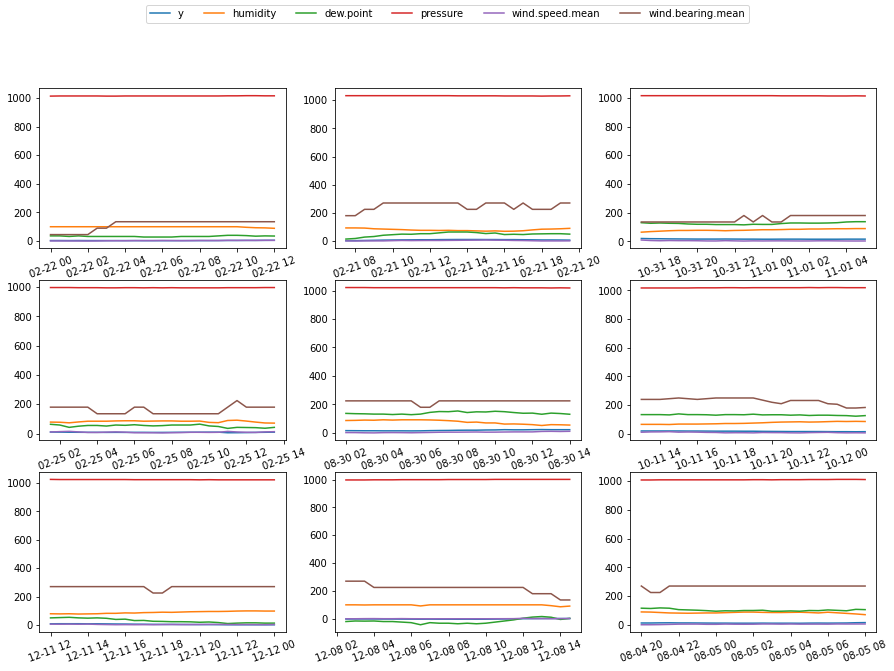

In [26]:
if 'google.colab' in str(get_ipython()):
    data_loc = "https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/data/CamMetCleanish2021.04.22.csv?raw=true"
else:
    data_loc = "../data/CamMetCleanish2021.04.22.csv"
df = pd.read_csv(data_loc, parse_dates = True)

df['ds'] = pd.to_datetime(df['ds'])
df['y'] = df['y'] / 10
df['wind.speed.mean'] = df['wind.speed.mean'] / 10

df = df.loc[df['ds'] > '2008-08-01 00:00:00',]

print("Shape:")
print(df.shape)
print("\nInfo:")
print(df.info())
print("\nSummary stats:")
display(df.describe())
print("\nRaw data:")
display(df)
print("\n")


def plot_examples(data, x_var):
    """Plot 9 sets of observations in 3 * 3 matrix ..."""

    assert len(data) == 9

    cols = [col for col in data[0].columns if col != x_var]

    fig, axs = plt.subplots(3, 3, figsize = (15, 10))
    axs = axs.ravel()  # apl for the win :-)

    for i in range(9):
      for col in cols:
        axs[i].plot(data[i][x_var], data[i][col])
        axs[i].xaxis.set_tick_params(rotation = 20, labelsize = 10)
    
    fig.legend(cols, loc = 'upper center',  ncol = len(cols))
    
    return None


cols = ['ds', 'y', 'humidity', 'dew.point', 'pressure', 
        'wind.speed.mean', 'wind.bearing.mean']
plots  = 9
window = 24
starts = [random.randint(0, np.floor(df.shape[0] / window)) for _ in range(plots)]
p_data = [df.loc[starts[i] * window:starts[i] * window + window, cols] 
          for i in range(plots)]
plot_examples(p_data, 'ds')



---

## Data Processing and Feature Engineering

The data must be reformatted before model building.

The following steps are necessary:

 * Wind direction and speed transformation
 * Time conversion
 * Split data?
 * Normalise data?
 * Window data?

### Wind direction and speed transformation

The wind.bearing.mean column gives wind direction in degrees but is mostly categorised at 45 degree increments, i.e. 0, 45, 90, 135, 180, 225, 270, 315. Wind direction shouldn't matter if the wind is not blowing.

The distribution of wind direction and speed looks like this:

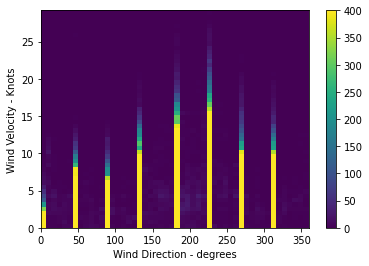

In [27]:
plt.hist2d(df['wind.bearing.mean'], df['wind.speed.mean'], bins = (50, 50), vmax = 400)
plt.colorbar()
plt.xlabel('Wind Direction - degrees')
plt.ylabel('Wind Velocity - Knots');

Convert wind direction and speed to x and y vectors, so the model can more easily interpret them.

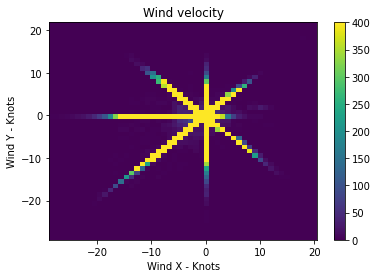

In [28]:
wv = df['wind.speed.mean']

# Convert to radians
wd_rad = df['wind.bearing.mean'] * np.pi / 180

# Calculate the wind x and y components
df['wind.x'] = wv * np.cos(wd_rad)
df['wind.y'] = wv * np.sin(wd_rad)

df_orig = df

plt.hist2d(df['wind.x'], df['wind.y'], bins = (50, 50), vmax = 400)
plt.colorbar()
plt.xlabel('Wind X - Knots')
plt.ylabel('Wind Y - Knots')
plt.title('Wind velocity');


Better, but not ideal. Data augmentation with the [mixup](https://arxiv.org/abs/1710.09412) method is carried out at batch preparation time below.

From the paper: "mixup trains a neural network on convex combinations of pairs of examples and their labels".

Further details on how I apply mixup to time series are included in the Window data section of the [keras_mlp_fcn_resnet_time_series.ipynb notebook](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/keras_mlp_fcn_resnet_time_series.ipynb).

Here is an illustration of the improvement in wind velocity with mixup augmentation.

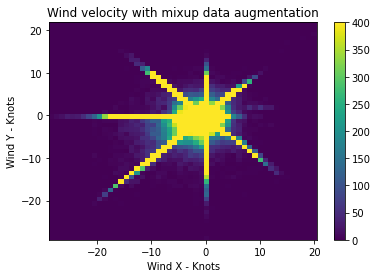

In [29]:
def mixup(data, alpha = 1.0, factor = 1):
    batch_size = len(data) - 1
    
    data['epoch'] = data.index.astype(np.int64) // 10**9
    
    # random sample lambda value from beta distribution
    l   = np.random.beta(alpha, alpha, batch_size * factor)
    X_l = l.reshape(batch_size * factor, 1)
    
    # Get a pair of inputs and outputs
    y1  = data['y'].shift(-1).dropna()
    y1_ = pd.concat([y1] * factor)
    
    y2  = data['y'][0:batch_size]
    y2_ = pd.concat([y2] * factor)

    X1  = data.drop('y', 1).shift(-1).dropna()
    X1_ = pd.concat([X1] * factor)
    
    X2  = data.drop('y', 1)
    X2  = X2[0:batch_size]
    X2_ = pd.concat([X2] * factor)

    # Perform mixup
    X = X1_ * X_l + X2_ * (1 - X_l)
    y = y1_ * l   + y2_ * (1 - l)    
    
    df = pd.DataFrame(y).join(X)    
    df = data.append(df).sort_values('epoch', ascending = True)
    df = df.drop('epoch', 1)
    
    df = df.drop_duplicates(keep = False)
    
    return df


df_mix = mixup(df.loc[:, ['y','wind.x','wind.y']], factor = 2)
plt.hist2d(df_mix['wind.x'], df_mix['wind.y'], bins = (50, 50), vmax = 400)
plt.colorbar()
plt.xlabel('Wind X - Knots')
plt.ylabel('Wind Y - Knots')
plt.title('Wind velocity with mixup data augmentation');

Mixup improves the categorical legacy of the wind velocity data. Unfortunately, if outliers are present their influence will be reinforced.

---

### Time conversion

Convert `ds` timestamps to "time of day" and "time of year" variables using `sin` and `cos`.

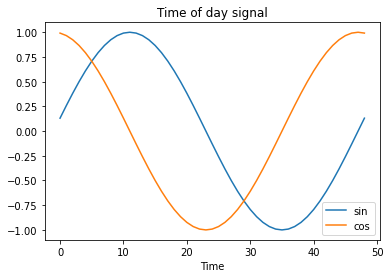

In [30]:
# Convert to secs
date_time   = pd.to_datetime(df['ds'], format = '%Y.%m.%d %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)

day  = 24 * 60 * 60
year = (365.2425) * day

df['day.sin']  = np.sin(timestamp_s * (2 * np.pi / day))
df['day.cos']  = np.cos(timestamp_s * (2 * np.pi / day))
df['year.sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['year.cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(df['day.sin'])[:49])
plt.plot(np.array(df['day.cos'])[:49])
plt.xlabel('Time')
plt.legend(['sin', 'cos'], loc = 'lower right')
plt.title('Time of day signal');

---

### Split data¶

Use data from 2018 for validation and 2019 for testing. These are entirely arbitrary choices. This results in an approximate 84%, 8%, 8% split for the training, validation, and test sets.

In [33]:
keep_cols = ['y', 'humidity', 'dew.point', 'pressure', 'wind.x', 'wind.y',
             'day.sin', 'day.cos', 'year.sin', 'year.cos', 'ds']

df['year'] = df['ds'].dt.year
train_df = df.loc[(df['year'] != 2018) & (df['year'] != 2019)]
valid_df = df.loc[df['year'] == 2018]
test_df  = df.loc[df['year'] == 2019]

train_df = train_df.drop('year', axis = 1)  # inplace = True gives SettingWithCopyWarning
valid_df = valid_df.drop('year', axis = 1)  # ...
test_df  = test_df.drop('year',  axis = 1)
df       = df.drop('year',       axis = 1)

print("df.drop shape: ", df.shape)
print("train shape:   ", train_df.shape)
print("valid shape:   ", valid_df.shape)
print("test shape:    ", test_df.shape)

df.drop shape:  (220870, 13)
train shape:    (186115, 13)
valid shape:    (17305, 13)
test shape:     (17450, 13)


---

## Baselines Methods

Which baseline methods:
 * mean
 * naive (persistent)
 * historical average
 * SES
 * HWES

...

Forecast horizons:
  * next 30 mins
  * next 2 hours
  * next 24 hours

...

Metrics:
 * rmse
 * mae
 * mape

...


From the plots, its worth noting:
 * ...


---


## Conclusion

Fortunately ...

On an unrelated matter ...

Future work:
 * ...

---

## Metadata

Python and Jupyter versions plus modules imported and their version strings. 
This is the poor man's python equivalent of R's sessionInfo().

Code for imported modules and versions adapted from this stackoverflow answer. 
There are simpler alternatives, such as watermark, but they all require installation.

In [34]:
import sys
import IPython

print("Python version:")
print(sys.executable)
print(sys.version)
print("\nIPython version:")
print(IPython.__version__)

Python version:
/usr/bin/python3
3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]

IPython version:
5.5.0


In [35]:
import pkg_resources
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names.  Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name.  You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL":       "Pillow",
            "sklearn":   "scikit-learn",
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

reqs = pd.DataFrame(requirements, columns = ['name', 'version'])
print("Imported modules:")
reqs.style.hide_index()

Imported modules:


name,version
statsmodels,0.10.2
pandas,1.1.5
numpy,1.19.5
matplotlib,3.2.2


In [36]:
!date

Thu Apr 22 20:52:55 UTC 2021


---


## Archival

Archive code, markdown, history and formatted notebooks.

Assumes all pdf, html, latex etc dependencies are installed.

**WARNING** Will overwrite existing files.

Notebook name is hardcoded below because the alternative is ghastly globs of unreliable javascript or external ipython libraries I'd prefer to avoid installing :-(

In [ ]:
from time import sleep

notebook = "cammet_baselines_2021.ipynb"
# !jupyter nbconvert --to script {notebook}
# !jupyter nbconvert --execute --to html {notebook}
# !jupyter nbconvert --execute --to pdf {notebook}
# !jupyter nbconvert --to pdf {notebook}

%rm history.txt
%history -f history.txt

!jupyter nbconvert --to python {notebook}
sleep(5)
!jupyter nbconvert --to markdown {notebook}
sleep(5)
!jupyter nbconvert --to html {notebook}